#### **PNGolin Test Notebook**

Demonstrates how to use PNGolin to compute the power spectrum, bispectrum, and trispectrum from a field. This uses a density field from the Quijote simulations that we read in using Pylians.

##### **Initialize notebook**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pngolin
import MAS_library as MASL

%config InlineBackend.figure_format='retina'
%matplotlib inline

##### **Initialize cosmology**
Generates CLASS cosmology object to test calculations from smulations. This isn't necessary for the estimators (except for the trispectrum which requires a fiducial power spectrum).

In [2]:
from classy import Class
from scipy.interpolate import CubicSpline

# Initialize cosmology
###############################################################
Omega_cdm = 0.3175-0.049
Omega_b   = 0.049
h         = 0.6711
n_s       = 0.9624
sigma8    = 0.834

param_dict = {'h': h, 'Omega_b': Omega_b, 
              'Omega_cdm': Omega_cdm, 
              'n_s': n_s, 'sigma8': sigma8,
              'output': 'mPk', 'P_k_max_h/Mpc': 20.0, 
              'z_max_pk': 1, 'non linear':'halofit',
              'T_cmb': 2.725,'N_ur': 3.046,
              'k_min_tau0': 0.01}
cosmo_quij = Class()
cosmo_quij.set(param_dict)
cosmo_quij.compute()

# Power spectrum mesh
k_thr = np.logspace(-4, 1, 10000)
Pk_lin_thr = np.asarray([cosmo_quij.pk_lin(ki*h, 0)*h**3 for ki in k_thr])
Pk_nonlin_thr = np.asarray([cosmo_quij.pk(ki*h, 0)*h**3 for ki in k_thr])
Pk_lin_interp_quij = CubicSpline(k_thr, Pk_lin_thr)
Pk_nonlin_interp_quij = CubicSpline(k_thr, Pk_nonlin_thr)



#*****************************************************************************
# Tree level bispectrum code
#*****************************************************************************
def get_Bmm_3D(k1, k2, k3, z, COSMO, use_linear=True):
    """
    Computes tree level matter bispectrum including Primordial 
    contribution from Eq. 22 of Takada+Jain
    """
    
    if hasattr(z, '__len__'):
        assert(len(z)==len(k1)), "If passing z as a vector, then len(z) must equal len(k1)"
    else:
        z = z*np.ones_like(k1)
    
    # Add triangle inequality check
    tol = 0.99999 # Necessary for numerical stability
    # assert (all((k1+k2)>=tol*k3) &
    #         all((k2+k3)>=tol*k1) & 
    #         all((k1+k3)>= tol*k2)), "Triangle inequality failed"
    
   
    #********************************************************************
    # Gravitational contribution
    #******************************************************************** 
    
    # Compute angle from law of cosines
    mu12 = (k3**2-k1**2-k2**2)/(2*k1*k2)
    mu23 = (k1**2-k2**2-k3**2)/(2*k2*k3)
    mu13 = (k2**2-k1**2-k3**2)/(2*k1*k3)
    
    # F2 kernel
    get_F2 = lambda k1,k2, mu12 : 10/7+mu12*(k1/k2+k2/k1)+4/7*mu12**2

    # Compute tree-level gravity contribution
    if use_linear:
        Pk1 = np.asarray([COSMO.pk_lin(k*h, z)*h**3 for (k,z) in zip(k1, z)])
        Pk2 = np.asarray([COSMO.pk_lin(k*h, z)*h**3 for (k,z) in zip(k2, z)])
        Pk3 = np.asarray([COSMO.pk_lin(k*h, z)*h**3 for (k,z) in zip(k3, z)])
    else:
        Pk1 = np.asarray([COSMO.pk(k*h, z)*h**3 for (k,z) in zip(k1, z)])
        Pk2 = np.asarray([COSMO.pk(k*h, z)*h**3 for (k,z) in zip(k2, z)])
        Pk3 = np.asarray([COSMO.pk(k*h, z)*h**3 for (k,z) in zip(k3, z)])

    perm1 = Pk1*Pk2*get_F2(k1, k2, mu12)
    perm2 = Pk2*Pk3*get_F2(k2, k3, mu23)
    perm3 = Pk3*Pk1*get_F2(k3, k1, mu13)

    B_tree_spt = perm1+perm2+perm3
    
    return B_tree_spt

##### **Load density field**
Loads density field from Quijote sims. Also uses pngolin.initialize_delta to construct the Fourier space field using CIC assignment

In [3]:
def construct_delta_pylians(snapstr, grid, ptypes=[1], MAS='CIC', do_RSD=False, 
                            axis=0, verbose=False):
    """
    Constructs density field from Gadget snapshot.
    """
    
    delta_x = MASL.density_field_gadget(snapstr, ptypes, grid, MAS, do_RSD, 
                                      axis, verbose)
    delta_x /= np.mean(delta_x, dtype=np.float64);  
    delta_x -= 1.0
    
    return delta_x

# Simulation settings
snapstr = '/work2/09407/samgolds/stampede3/lib/quijote_sims/fiducial/0/snapdir_004/snap_004'
boxsize = 1000
kf      = 2*np.pi/boxsize

nthreads = 10

# Snapshot loading functions
ngrid = 128 # Sets size of FFT to use for analysis. Probably want 1024 for Quijote depending on kmax.
k_nyq   = ngrid//2*kf
print("Nyquist Frequency: {:.2f} h/Mpc".format(k_nyq))
delta_x = construct_delta_pylians(snapstr, ngrid)
delta_k = pngolin.initialize_delta(delta_x, MAS='CIC', nthreads=nthreads)

Nyquist Frequency: 0.40 h/Mpc


#### **Compute power spectrum**

Text(0, 0.5, '$P(k)~[{\\rm Mpc}^3/h^3]$')

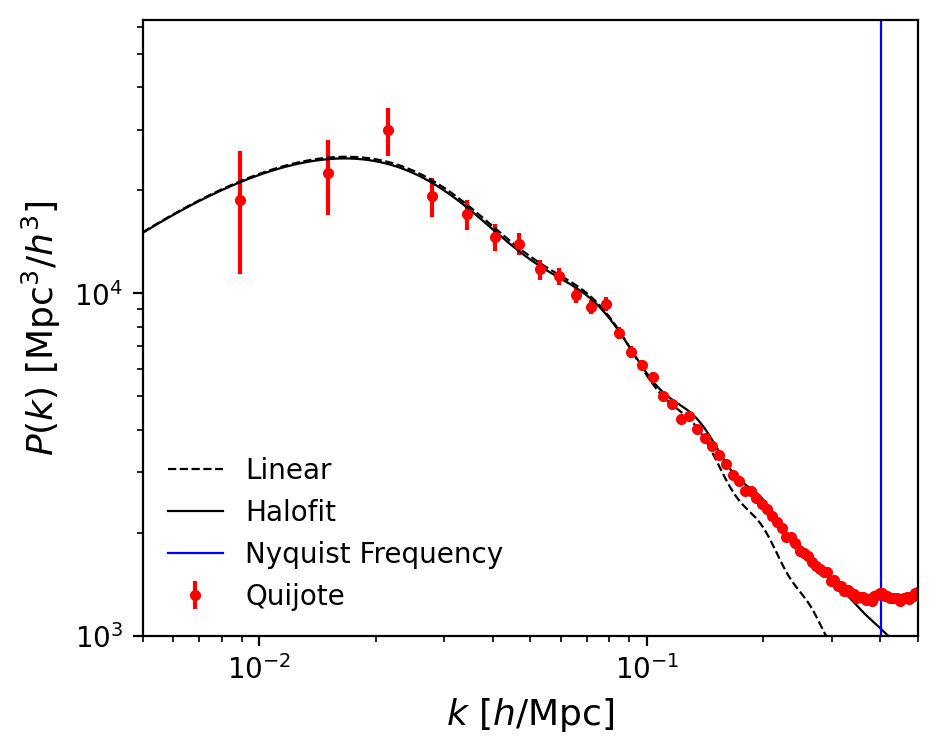

In [4]:
# Bin settings for power spectrum. Note that bins are specified as integer multiples of kf
kmin = 1
kmax = 100
dk   = 1
k, Pk, Nmodes = pngolin.compute_Pk3D_binned(delta_k, kmin, kmax, dk, boxsize, nthreads=1)

plt.figure(figsize=(5,4))
plt.errorbar(k, Pk, yerr=np.sqrt((2*Pk**2/Nmodes)), linestyle='None', marker='.', color='r', label='Quijote')
plt.plot(k_thr, Pk_lin_thr, color='k', linestyle='--', label='Linear', linewidth=0.8)
plt.plot(k_thr, Pk_nonlin_thr, color='k', linestyle='-', label=r'Halofit', linewidth=0.8)
plt.axvline(k_nyq, label='Nyquist Frequency', color='b', linewidth=0.8)
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.005, 0.5)
plt.ylim(bottom=1000)
plt.xlabel(r"$k~[h/{\rm Mpc}]$", fontsize=13)
plt.ylabel(r"$P(k)~[{\rm Mpc}^3/h^3]$", fontsize=13)

#### **Compute bispectrum**

We comptue the bispectrum by specifying bin limits for $k_1,k_2,k_3$ and their bin widths. Note that this computes all non-trivial bins with $k_1<k_2<k_3$. Additionally, if you are computing the estimator for multiple realizations, then you only need to compute the normalization (which is realiation independent) once and can then pass this to future calculations of estimators. I think Ntriangles doesn't have correct normalization. It should have additional factors of $k_F$, but I will fix this later. We compare with tree-level prediction (although I don't show the errorbars).

1. INITIALIZING BINS
-> Total number of bins: 32
-> Number of unique k windows: 5
-> Time taken: 0.003 seconds
2. COMPUTING UNIQUE WINDOWED FIELDS AND THEIR IFFTS
-> Normalization not specified. Computing this too!
-> Time taken: 0.248 seconds
3. COMPUTING BINNED BISPECTRUM
-> Time taken: 0.065 seconds


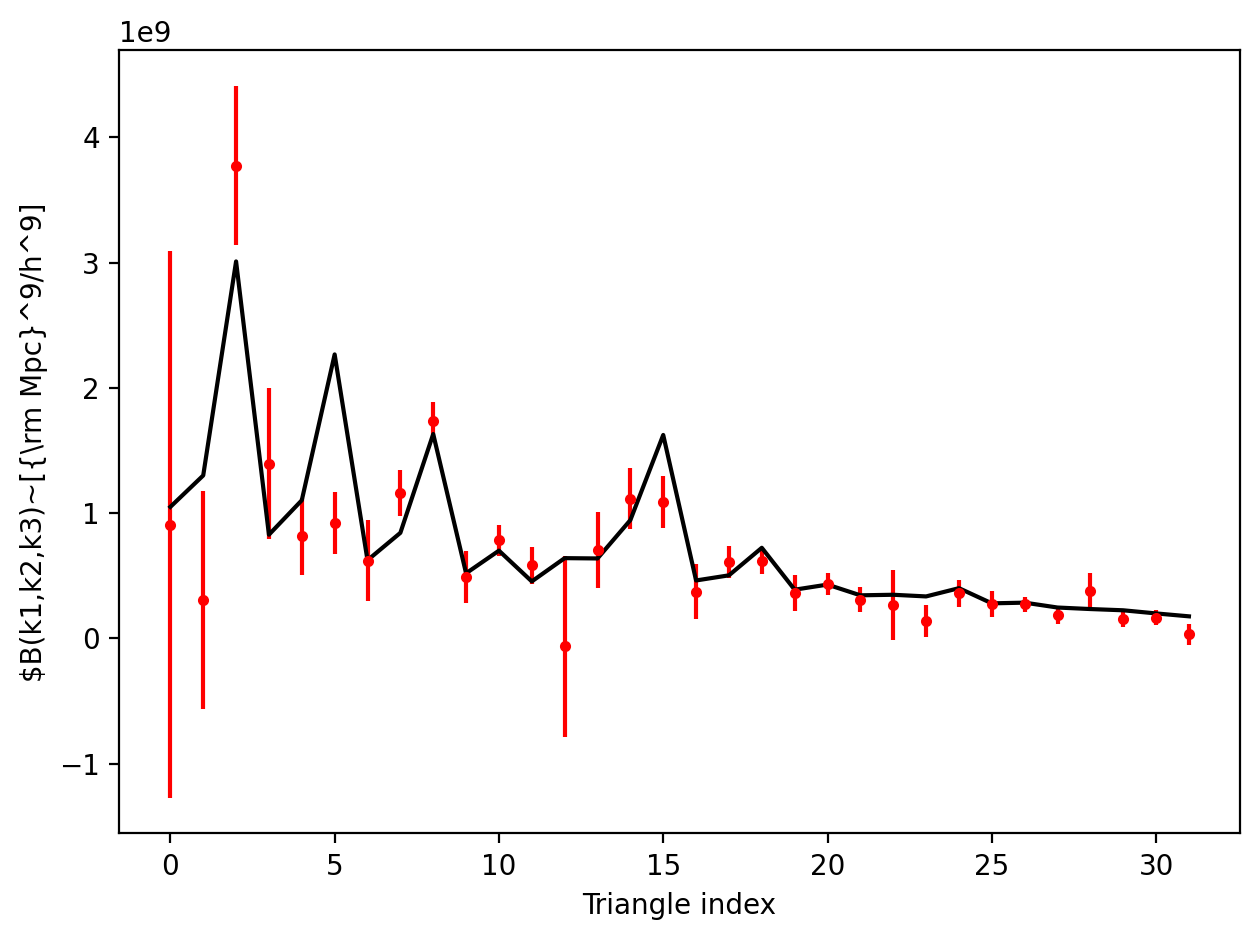

In [5]:
### Bispectrum settings. Computes all non-trivial bins with k1<k2<k3
k1_min = 2
k1_max = 12
k2_min = 2
k2_max = 12
k3_min = 2
k3_max = 12
dk1 = 2
dk2 = 2
dk3 = 2


kBk, Bk_arr, Ntri_arr = pngolin.compute_bk3d(delta_k, k1_min, k1_max, k2_min, k2_max, k3_min, k3_max,
                                             dk1, dk2, dk3, boxsize, nthreads=nthreads, verbose=True)

# Once you have Ntri_arr 
# kBk, Bk_arr, _ = pngolin.compute_bk3d(delta_k, k1_min, k1_max, k2_min, k2_max, k3_min, k3_max,
#                                              dk1, dk2, dk3, boxsize, nthreads=nthreads, verbose=True, Bqnorm_arr=Ntri_arr)

# Continuous approximation for Gaussian covariance (Eq. 11 of 2206.10458)
k1, k2, k3 = kBk.T
Pk1 = Pk_lin_interp_quij(k1)
Pk2 = Pk_lin_interp_quij(k2)
Pk3 = Pk_lin_interp_quij(k3)

s123 = 1*np.ones_like(k1)
s123[np.where((k1==k2) | (k2==k3) |  (k3==k1))] = 2
s123[np.where((k1==k2) & (k2==k3))] = 6

V123 = 8*np.pi**2*k1*k2*k3*(dk1*kf)**3
cov_gauss = (2*np.pi)**3*kf**3*s123*Pk1*Pk2*Pk3/V123

# Unpack bins
k1,k2,k3  = kBk.T
Bk_tree = get_Bmm_3D(k1,k2,k3, 0, cosmo_quij)
tri_ind = np.arange(len(k1))
plt.errorbar(tri_ind, Bk_arr, yerr=np.sqrt(cov_gauss), marker='.', linestyle='None', color='r')
plt.plot(tri_ind, Bk_tree, color='k')
plt.xlabel(r"Triangle index")
plt.ylabel(r"$B(k1,k2,k3)~[{\rm Mpc}^9/h^9]")
plt.tight_layout()